<a href="https://colab.research.google.com/github/MEskerod/project_deeplearning_2023/blob/main/deeplearning_project_Maria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
#Import all
import tarfile, os, torch

import random as rd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from fnmatch import fnmatch

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

from torch.nn.modules import padding
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.functional import leaky_relu

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/RNAStralign.tar.gz' #Change!

# Define the folder where you want to unzip the files (in-memory)
extracted_folder = '/content/sequences' #Change name?!

# Import files

In [4]:
# Create the destination folder (in-memory)
os.makedirs(extracted_folder, exist_ok=True)

# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(extracted_folder)

# List the files in the extracted folder
os.listdir(extracted_folder)

['RNAStrAlign-master-aedbaf9e95ebad34d15752fe1b750f5ff3960bca']

In [5]:
root = extracted_folder
pattern = "*.ct"

number_files = 0

ct_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
          #ct_files.append(os.path.join(path, name))
          file = os.path.join(path, name)
          with open(file, 'r') as f:
            length = int(f.readline().split()[0])
          if length < 500 and '5S_rRNA' not in file: #NOTE! Change length
            number_files += 1
            ct_files.append(file)
with open("ct_files.txt", "w") as output:
    output.write("\n".join(ct_files))

number_files


13876

### Picking files

In [6]:
def singleFamily(family: str, txt_file="ct_files.txt") -> list:
    '''
    Returns list of files from a single specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family in line:
                ct_files.append(line.strip())
    return ct_files

def leaveOneFamilyOut(family: str, txt_file="ct_files.txt"):
    '''
    Returns list of files from all families except the specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family not in line:
                ct_files.append(line.strip())
    return ct_files

def pickFromFamilies(data_size, txt_file="ct_files.txt"):
    '''
    Returns a list of files with data_size from EACH family.
    If a family does not have enough data, all data from that family is added.
    '''
    ct_files = []
    with open(txt_file, "r") as file: #Read paths to ct_files
        for line in file:
            if not line.startswith("#"):
                ct_files.append(line.strip())

    families = []
    for file in ct_files: #Find all family names
        families.append(file.split("\\")[2])
    families = list(set(families)) #Remove duplicates

    data = [] #Create list of lists, where each list contains all files from a family
    for family in families:
        data.append([line for line in ct_files if family in line])

    ct_files = []
    for family in data: #Pick data_size files from each family
        try:
            ct_files.append(rd.sample(family, data_size))
        except:
            print("Not enough data in family: ", family[0].split("\\")[2], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")

    return ct_files


# Set up preprocessing of RNA files   

Below are the functions that is needed for processing the files from .ct files to images

In [7]:
def read_bpseq(file: str) -> tuple():
    """
    Takes a .bpseq file and returns the sequence as a string and a list of base pairs
    """

    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    #Make sequence in bp list
    for line in lines:
        sequence += line[1]
        if line[2] != '0':
            pairs.append((int(line[0])-1, int(line[2])-1)) #The files start indexing from 1
    return sequence, pairs

def read_ct(file: str) -> tuple():
    """
    Takes a .ct file and returns the sequence as a string and a list of base pairs
    """
    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    for line in lines:
        sequence += line[1]
        if line[4] != '0':
            pairs.append((int(line[0])-1, int(line[4])-1)) #The files start indexing from 1

    return sequence, pairs

In [8]:
def make_matrix_from_sequence(sequence: str) -> np.array:
    """
    A sequence is converted to a matrix containing all the possible base pairs

    If the bases does not form  valid pair the cell is white.
    The valid base pairs has the following colors:
    GC = green
    CG = dark green
    UG = blue
    GU = dark blue
    UA = red
    AU = dark red
    """
    colors = {"invalid_pairing": [255, 255, 255],
              "unpaired": [64, 64, 64],
              "GC": [0, 255, 0],
              "CG": [0, 128, 0],
              "UG": [0, 0, 255],
              "GU": [0, 0, 128],
              "UA": [255, 0, 0],
              "AU": [128, 0, 0]}
    basepairs = ["GC", "CG", "UG", "GU", "UA", "AU"]

    N = len(sequence)

    matrix = np.full((N,N,3),255, dtype="uint8")

    for i in range(N):
        for j in range(N):
            pair = sequence[i] + sequence[j]
            if i == j:
                matrix[i, j, :] = colors["unpaired"]
            elif pair in basepairs:
                matrix[i, j, :] = colors[pair]

    if N%2==0:
      row = np.full((1, N, 3), 0, dtype="uint8")
      column = np.full((N+1, 1, 3), 0, dtype="uint8")
      matrix = np.append(matrix, row, axis = 0)
      matrix = np.append(matrix, column, axis = 1)

    return matrix


def make_matrix_from_basepairs(sequence: str, pairs: list) -> np.array:
    """
    Takes a list of all the base pairs.
    From the list a matrix is made, with each cell coresponding to a base pair colered black
    """
    black = [0, 0, 0]

    N = len(sequence)
    matrix = np.full((N,N,3),255, dtype="uint8")

    for pair in pairs:
        matrix[pair[0], pair[1], :] = black

    if N%2==0:
      row = np.full((1, N, 3), 0, dtype="uint8")
      column = np.full((N+1, 1, 3), 0, dtype="uint8")
      matrix = np.append(matrix, row, axis = 0)
      matrix = np.append(matrix, column, axis = 1)

    return matrix

In [9]:
def save_matrix(matrix: np.array, name: str) -> None:
    """
    Saves the matrix as a .png file
    """
    plt.imsave(name, matrix)

# Convert sequences
The sequences needs to be read from the .ct files and converted into images that can be used as input to the CNN.    

In [10]:

def getCtFromTxt(txt_file):
    """
    Takes a txt file containing the path to all the ct files and returns a list of the paths
    """
    with open(txt_file, 'r') as f:
        ct_files = f.readlines()
    ct_files = [file.strip() for file in ct_files if file.strip()[0] != "#"]
    return ct_files

def save_to_matrices(file_list, input_matrix_path, output_matrix_path):
    """
    For every file supplied in file_list:
      a matrix of all possible base pairs is saved to input_matrix_path
      a matrix showing the base pairs in the actual sequence is saved to output_matrix_path
    """
    for file_name in file_list:
        sequence, pairs = read_ct(file_name)
        input_matrix = make_matrix_from_sequence(sequence)
        save_matrix(input_matrix, os.path.join(input_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))
        output_matrix = make_matrix_from_basepairs(sequence, pairs)
        save_matrix(output_matrix, os.path.join(output_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))

In [11]:
#TODO - Change to different file list! This is just for testing.

ct_files = getCtFromTxt("ct_files.txt")

#file_list = []

#for file_name in ct_files:
    #if "tRNA_database" in file_name:
    #    file_list.append(file_name)



file_list = ct_files
len(file_list)



13876

In [12]:
input_matrix_path = "input"
output_matrix_path = "result"

# Create folders for images
os.makedirs(input_matrix_path, exist_ok=True)
os.makedirs(output_matrix_path, exist_ok=True)

save_to_matrices(file_list, input_matrix_path, output_matrix_path)


# Set up data for network

### Splitting data into train and validation sets

In [13]:
def move_files(src_dir, dst_dir, file_list):
    for filename in file_list:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        os.rename(src_path, dst_path)

In [14]:
#Make directories
directories = ['train', 'validation']
subdirectories = ['input_images', 'output_images']

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    for subdirectory in subdirectories:
        dir_path = os.path.join(directory, subdirectory)
        os.makedirs(dir_path, exist_ok=True)

In [15]:
#List input and outputs
input_images = os.listdir(input_matrix_path)
output_images = os.listdir(output_matrix_path)

#Make split
input_train, input_valid, output_train, output_valid = train_test_split(input_images, output_images, train_size=0.8, random_state=42, shuffle=True) #NOTE - Change to the fraction we want nd whether we want shuffle or not


#Move files to train and validation folders
train_input_dir = 'train/input_images'
train_output_dir = 'train/output_images'
val_input_dir = 'validation/input_images'
val_output_dir = 'validation/output_images'

move_files(input_matrix_path, train_input_dir, input_train)
move_files(output_matrix_path, train_output_dir, output_train)
move_files(input_matrix_path, val_input_dir, input_valid)
move_files(output_matrix_path, val_output_dir, output_valid)

### Read data and set up data loader

In [16]:
dataTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
])

class ImageToImageDataset(Dataset):
    """

    """
    def __init__(self, input_dir, output_dir, input_transform = dataTransformer, output_transform = dataTransformer):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = os.listdir(input_dir)
        self.output_files = os.listdir(output_dir)
        self.input_transform = input_transform
        self.output_transform = output_transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image =  plt.imread(os.path.join(self.input_dir, self.input_files[idx]))
        output_image = plt.imread(os.path.join(self.output_dir, self.output_files[idx]))

        input_image = self.input_transform(input_image)
        output_image = self.output_transform(output_image)

        return input_image, output_image



### Image transformers

In [17]:
def convert_to_grayscale(img):
  return torch.mean(img, dim=0, keepdim=True)

def drop_alpha(img):
  return img[:3, :, :]

grayscaleTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
    transforms.Lambda(convert_to_grayscale)
])

RGBTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
    transforms.Lambda(drop_alpha)
])

# Model

In [18]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class RNASecondaryStructureCAE(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNASecondaryStructureCAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels * 2,
                kernel_size=3,
                padding=1,
                # Maybe use dilation in deeper layers?
            ),
            nn.BatchNorm2d(out_channels * 2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(in_channels=out_channels * 2,
                      out_channels=out_channels * 4,
                      kernel_size=3,
                      padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # Doesn't make sense for our data?
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=out_channels * 4,
                out_channels=out_channels * 2,
                kernel_size=3,
                stride=2
            ),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(
                in_channels=out_channels * 2,
                out_channels=out_channels,
                kernel_size=3,
                padding=1
            ),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(
                in_channels=out_channels,
                out_channels=in_channels,
                kernel_size=3,
                padding=1,
            ),
            Lambda(lambda x: x.mean(dim=1, keepdim=True)), #Used to change output to (1, 1, N, N)
            nn.Sigmoid()
        )

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class RNA_Unet(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet, self).__init__()

        # Encoder
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.e11 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.e12 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        self.bn2 = nn.BatchNorm2d(out_channels * 2)
        self.e21 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.e31 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=3, stride=2)
        self.d11 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=3, padding=1)
        self.d21 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=3, padding=1)
        self.d31 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(Lambda(lambda x: x.mean(dim=1, keepdim=True)), #Used to change output to (1, 1, N, N)
            nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        #Encoder
        xe11 = self.bn1(leaky_relu(self.e11(x)))
        xe12 = self.bn1(leaky_relu(self.e12(xe11)))

        xe21 = self.bn2(leaky_relu(self.e21(xe12)))
        xe22 = self.bn2(leaky_relu(self.e22(xe21)))

        xe31 = self.bn3(leaky_relu(self.e31(xe22)))
        xe32 = self.bn3(leaky_relu(self.e32(xe31)))

        xp = self.pool(xe32)

        #Decoder
        xu1 = leaky_relu(self.upconv1(xp))
        xd11 = leaky_relu(self.d11(xu1))

        xu2 = leaky_relu(self.upconv2(xd11))
        xd21 = leaky_relu(self.d21(xu2))

        xu3 = leaky_relu(self.upconv3(xd21))
        xd31 = leaky_relu(self.d31(xu3))

        out = self.out(xd31)

        return out

In [46]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class RNA_Unet_com(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet_com, self).__init__()

        # Encoder
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.e11 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.e12 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        self.bn2 = nn.BatchNorm2d(out_channels * 2)
        self.e21 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.e31 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=3, stride=2)
        self.d11 = nn.Conv2d(out_channels*4, out_channels*2, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=3, padding=1)
        self.d21 = nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=3, padding=1)
        self.d31 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(Lambda(lambda x: x.mean(dim=1, keepdim=True)), #Used to change output to (1, 1, N, N)
            nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        #Encoder
        xe11 = self.bn1(leaky_relu(self.e11(x)))
        xe12 = self.bn1(leaky_relu(self.e12(xe11)))

        xe21 = self.bn2(leaky_relu(self.e21(xe12)))
        xe22 = self.bn2(leaky_relu(self.e22(xe21)))

        xe31 = self.bn3(leaky_relu(self.e31(xe22)))
        xe32 = self.bn3(leaky_relu(self.e32(xe31)))

        xp = self.pool(xe32)

        #Decoder
        xu1 = leaky_relu(self.upconv1(xp))
        xu11 = torch.cat([xu1, xe22], dim=1)
        xd11 = leaky_relu(self.d11(xu11))

        xu2 = leaky_relu(self.upconv2(xd11))
        xu22 = torch.cat([xu2, xe12], dim=1)
        xd21 = leaky_relu(self.d21(xu22))

        xu3 = leaky_relu(self.upconv3(xd21))
        xd31 = leaky_relu(self.d31(xu3))

        out = self.out(xd31)

        return out

In [35]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class RNA_Unet_com2(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet_com2, self).__init__()

        # Encoder
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.e11 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.e12 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride =2, padding = 1)

        self.bn2 = nn.BatchNorm2d(out_channels * 2)
        self.e21 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding =1)

        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.e31 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding = 1)

        self.bn4 = nn.BatchNorm2d(out_channels*8)
        self.e41 = nn.Conv2d(out_channels*4, out_channels*8, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(out_channels*8, out_channels*4, kernel_size=2, stride=2, padding =1)
        self.d11 = nn.Conv2d(out_channels*8, out_channels*4, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=2, stride=2, padding = 1)
        self.d21 = nn.Conv2d(out_channels*4, out_channels*2, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding = 1)

        self.upconv3 = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=2, stride=2, padding = 1)
        self.d31 = nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1)

        self.upconv4 = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=3, padding=1)
        self.out = nn.Sequential(Lambda(lambda x: x.mean(dim=1, keepdim=True)), #Used to change output to (1, 1, N, N)
            nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        #Encoder
        xe11 = self.bn1(leaky_relu(self.e11(x)))
        xe12 = self.bn1(leaky_relu(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = self.bn2(leaky_relu(self.e21(xp1)))
        xe22 = self.bn2(leaky_relu(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xe31 = self.bn3(leaky_relu(self.e31(xp2)))
        xe32 = self.bn3(leaky_relu(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xe41 = self.bn4(leaky_relu(self.e41(xp3)))
        xe42 = self.bn4(leaky_relu(self.e42(xe41)))

        #Decoder
        xu1 = leaky_relu(self.upconv1(xe42))
        xu11 = torch.cat([xu1, xe32], dim=1)
        xd11 = leaky_relu(self.d11(xu11))

        xu2 = leaky_relu(self.upconv2(xd11))
        xu22 = torch.cat([xu2, xe22], dim=1)
        xd21 = leaky_relu(self.d21(xu22))

        xu3 = leaky_relu(self.upconv3(xd21))
        xu33 = torch.cat([xu3, xe12], dim=1)
        xd31 = leaky_relu(self.d31(xu33))

        xu4 = leaky_relu(self.upconv4(xd31))
        out = self.out(xd31)

        return out

### Function for training the model

### Loss functions and accuracy

In [19]:
def dice_loss(inputs, targets, smooth=1e-5):
  intersection = torch.sum(targets * inputs, dim=(1,2,3))
  sum_of_squares_pred = torch.sum(torch.square(inputs), dim=(1,2,3))
  sum_of_squares_true = torch.sum(torch.square(targets), dim=(1,2,3))
  dice = (2 * intersection + smooth) / (sum_of_squares_pred + sum_of_squares_true + smooth)
  return 1-dice

In [20]:
def accuracy(inputs, targets, treshold = 0.5):
  if inputs.shape != targets.shape:
        raise ValueError("ERROR: Input tensors must have the same shape.")

  correct_predicted = torch.sum((inputs >= treshold).float() == targets)
  total_elements = inputs.numel()
  return correct_predicted/total_elements

### Optimizers

In [21]:
def adam_optimizer(model, lr):
  return torch.optim.Adam(model.parameters(), lr=lr)

### Plots for training

In [22]:
def show_matrices(inputs, observed, predicted):

  fig, axs = plt.subplots(1, 3, figsize=(6,2))

  axs[0].imshow(inputs.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[0].set_title("Input")

  axs[1].imshow(observed.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy(), cmap="gray")
  axs[1].set_title("Observed")

  axs[2].imshow(predicted.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy(), cmap = "gray")
  axs[2].set_title("Predicted")

  plt.tight_layout()
  plt.show()


def show_loss(train_loss, valid_loss, time):
  plt.figure()
  plt.plot(time, train_loss, label = "Training")
  plt.plot(time, valid_loss, label = "Valiation")
  plt.title("Loss")
  plt.legend()
  plt.show()

def show_acuracy(train_accuracy, valid_accuracy, time):
  plt.figure()
  plt.plot(time, train_accuracy, label = "Training")
  plt.plot(time, valid_accuracy, label = "Validation")
  plt.title("Accuracy")
  plt.legend()
  plt.show()


### Funcition for training

In [28]:
def fit_model(model, train_dataset, validation_dataset, loss_func = F.binary_cross_entropy, optimizer = adam_optimizer, lr=0.01, bs=1, epochs=5):
  train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  valid_dl = DataLoader(validation_dataset, batch_size=bs)

  opt = optimizer(model, lr)


  #Add stuff to track history
  train_loss_history = []
  train_accuracy_history = []
  valid_loss_history = []
  valid_accuracy_history = []
  plot_time = []

  t = 0 #To keep track of time

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(input.cuda()), output.cuda()) for input, output in valid_dl) / len(valid_dl)
    valid_accuracy = sum(accuracy(model(input.cuda()), output.cuda()) for input, output in valid_dl) / len(valid_dl)
    train_loss = sum(loss_func(model(input.cuda()), output.cuda()) for input, output in train_dl) / len(train_dl)
    train_accuracy = sum(accuracy(model(input.cuda()), output.cuda()) for input, output in train_dl) / len(train_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    valid_accuracy_history.append(valid_accuracy.detach().cpu().numpy())
    train_loss_history.append(train_loss.detach().cpu().numpy())
    train_accuracy_history.append(train_accuracy.detach().cpu().numpy())
    plot_time.append(t)

  #Train for a given number of epochs
  for epoch in range(epochs):
    t+=1
    running_loss = 0.0
    running_accuracy = 0.0
    model.train()

    for input, output in train_dl:
      output = output.mean(dim=1, keepdim=True)

      #Forward pass
      predicted = model(input.cuda())

      #Compute loss
      loss = loss_func(predicted, output.cuda())
      running_loss += loss.item()

      running_accuracy += accuracy(predicted, output.cuda()).item()

      # Backpropagation, optimization and zeroing the gradients
      loss.backward()
      opt.step()
      opt.zero_grad()

    #Validation loss (only after each epoch)
    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_func(model(input.cuda()), output.cuda()) for input, output in valid_dl)/len(valid_dl)
      valid_accuracy = sum(accuracy(model(input.cuda()), output.cuda()) for input, output in valid_dl) / len(valid_dl)
      valid_loss_history.append(valid_loss.detach().cpu().numpy())
      valid_accuracy_history.append(valid_accuracy.detach().cpu().numpy())
      train_loss_history.append(running_loss/len(train_dl))
      train_accuracy_history.append(running_accuracy/len(train_dl))
      plot_time.append(t)



    show_matrices(input, output, predicted)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {round(running_loss / len(train_dl),4)}")

  #Loss plot
  show_loss(train_loss_history, valid_loss_history, plot_time)
  show_acuracy(train_accuracy_history, valid_accuracy_history, plot_time)

  return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history, plot_time


# Training models

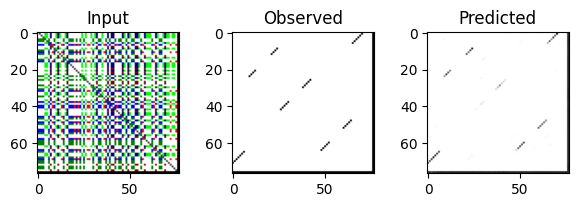

Epoch [1/5], Loss: 0.0158


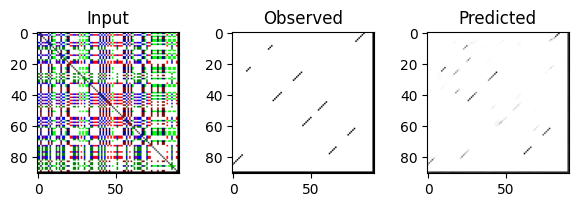

Epoch [2/5], Loss: 0.0133


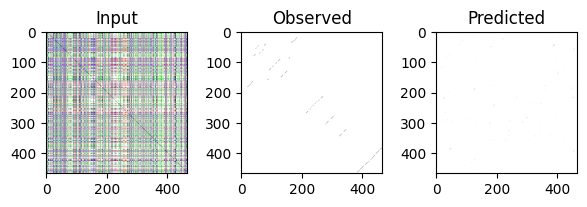

Epoch [3/5], Loss: 0.013


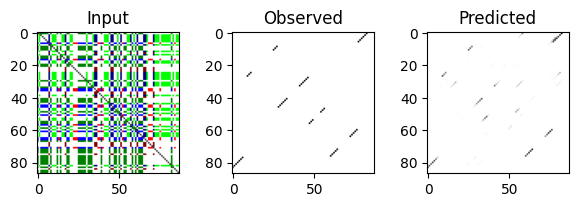

Epoch [4/5], Loss: 0.0127


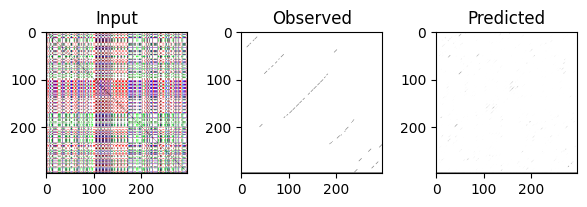

Epoch [5/5], Loss: 0.0126


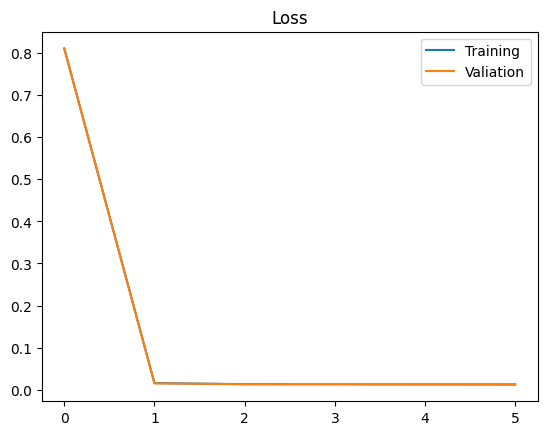

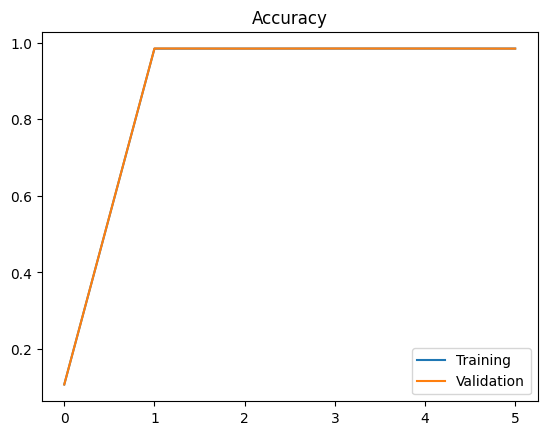

([array(0.8106032, dtype=float32),
  0.015847016803270712,
  0.013348250368031245,
  0.013007520417963242,
  0.012738759324345041,
  0.012581897212101963],
 [array(0.10762557, dtype=float32),
  0.9844225057296534,
  0.9845524404012896,
  0.9845907087510694,
  0.9846033767360504,
  0.9846169787392426],
 [array(0.81069154, dtype=float32),
  array(0.01517441, dtype=float32),
  array(0.0132362, dtype=float32),
  array(0.01360754, dtype=float32),
  array(0.0131539, dtype=float32),
  array(0.01290686, dtype=float32)],
 [array(0.10770325, dtype=float32),
  array(0.9848291, dtype=float32),
  array(0.9845125, dtype=float32),
  array(0.9847599, dtype=float32),
  array(0.984692, dtype=float32),
  array(0.9844572, dtype=float32)],
 [0, 1, 2, 3, 4, 5])

In [24]:
#Original model
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)

%matplotlib inline

channels = 8
model_original = RNASecondaryStructureCAE(channels).cuda()

fit_model(model_original, train_dataset, validation_dataset)

print("Finished training")

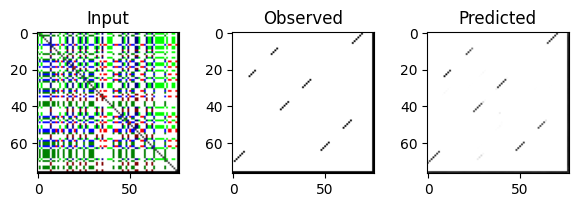

Epoch [1/5], Loss: 0.0138


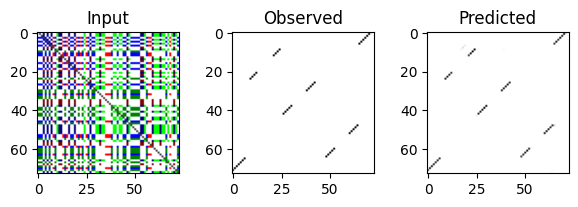

Epoch [2/5], Loss: 0.0118


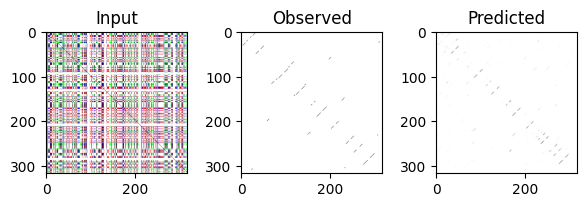

Epoch [3/5], Loss: 0.0115


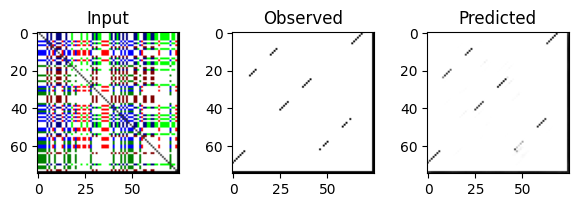

Epoch [4/5], Loss: 0.0115


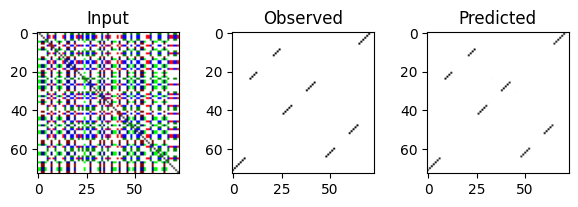

Epoch [5/5], Loss: 0.0115


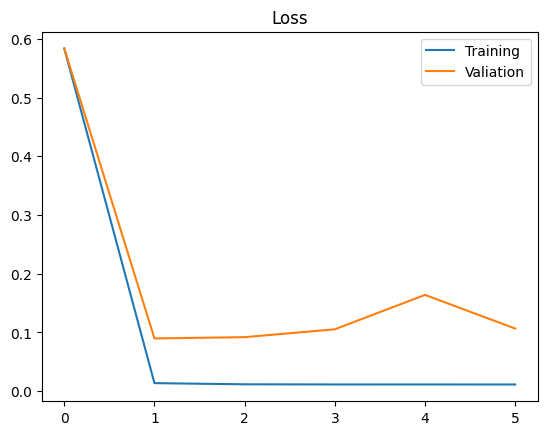

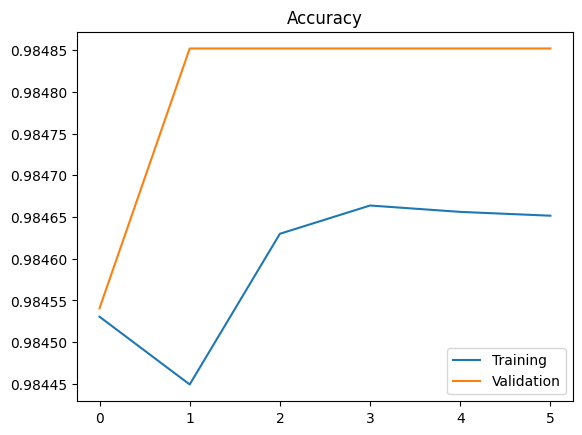

In [38]:
#With more layers
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)

%matplotlib inline

channels = 8
model_new = RNA_Unet(channels).cuda()

fit_model(model_new, train_dataset, validation_dataset)

print("Finished training")

In [ ]:
#With skip layers
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)

%matplotlib inline

channels = 8
model_unet = RNA_Unet_com(channels).cuda()

fit_model(model_unet, train_dataset, validation_dataset)

print("Finished training")